In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
# X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(num_training=5000, num_validation=1000, num_test=2000)
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [16]:
def run_model(writer, merged, session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [merged, mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            summary, loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            writer.add_summary(summary, i*e)
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct



In [21]:
def my_model(X,y,is_training):
    #32x32x3
    net = tf.layers.conv2d(X, filters=32, kernel_size=[3,3], padding='same',
                           activation=tf.nn.leaky_relu)
    #32x32x32
    net = tf.layers.conv2d(X, filters=32, kernel_size=[3,3], padding='same',
                           activation=tf.nn.leaky_relu)
    net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
        
    #16x16x32
    net = tf.layers.batch_normalization(net, training=is_training)
    net = tf.layers.conv2d(net, filters=64, kernel_size=[3,3], padding='same',
                          activation=tf.nn.leaky_relu)
    #16x16x64
    net = tf.layers.conv2d(net, filters=64, kernel_size=[3,3], padding='same',
                          activation=tf.nn.leaky_relu)
    net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
    
    #8x8x64
    net = tf.layers.batch_normalization(net, training=is_training)
    net = tf.layers.conv2d(net, filters=128, kernel_size=[3,3], padding='same',
                          activation=tf.nn.leaky_relu)
    #8x8x128
    net = tf.layers.conv2d(net, filters=128, kernel_size=[3,3], padding='same',
                          activation=tf.nn.leaky_relu)
    net = tf.layers.conv2d(net, filters=128, kernel_size=[3,3], padding='same',
                          activation=tf.nn.leaky_relu)
    net = tf.layers.max_pooling2d(net, pool_size=[2,2], strides=2)
    
    #4x4x128
    net = tf.reshape(net, [-1, 4*4*128])
    # nx(4*4*32) = nx2048
    net = tf.layers.dense(net, units=1024, activation=tf.nn.relu)
    net = tf.layers.dropout(net, rate=0.7, training=is_training)
    # nx1024
    net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
    net = tf.layers.dropout(net, rate=0.5, training=is_training)
    # nx512 (note: no activation in the last layer) 
    net = tf.layers.dense(net, units=10)
    # nx10 
    return net

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_out)
mean_loss = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
tf.summary.scalar("cross_entropy_loss", mean_loss)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.9 and accuracy of 0.062
Iteration 100: with minibatch training loss = 1.73 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.69 and accuracy of 0.39
Iteration 300: with minibatch training loss = 1.26 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.48 and accuracy of 0.52
Iteration 500: with minibatch training loss = 1.45 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.18 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.41 and accuracy of 0.55
Epoch 1, Overall loss = 1.49 and accuracy of 0.463


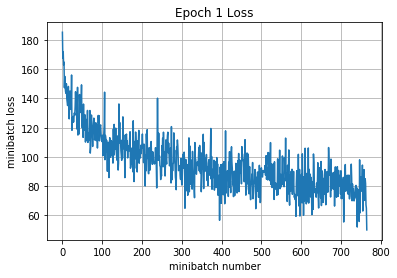

Iteration 800: with minibatch training loss = 1.23 and accuracy of 0.56
Iteration 900: with minibatch training loss = 1.03 and accuracy of 0.66
Iteration 1000: with minibatch training loss = 1.13 and accuracy of 0.64
Iteration 1100: with minibatch training loss = 1.29 and accuracy of 0.48
Iteration 1200: with minibatch training loss = 0.916 and accuracy of 0.67
Iteration 1300: with minibatch training loss = 1.05 and accuracy of 0.66
Iteration 1400: with minibatch training loss = 0.913 and accuracy of 0.61
Iteration 1500: with minibatch training loss = 0.751 and accuracy of 0.69
Epoch 2, Overall loss = 1.1 and accuracy of 0.621


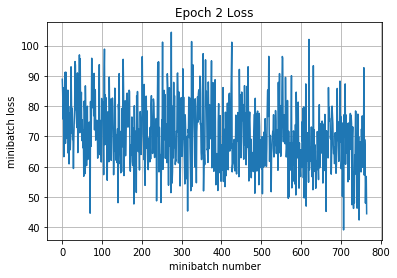

Iteration 1600: with minibatch training loss = 0.812 and accuracy of 0.7
Iteration 1700: with minibatch training loss = 1 and accuracy of 0.62
Iteration 1800: with minibatch training loss = 0.987 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 1.1 and accuracy of 0.69
Iteration 2000: with minibatch training loss = 1.08 and accuracy of 0.58
Iteration 2100: with minibatch training loss = 0.65 and accuracy of 0.77
Iteration 2200: with minibatch training loss = 0.987 and accuracy of 0.61
Epoch 3, Overall loss = 0.965 and accuracy of 0.67


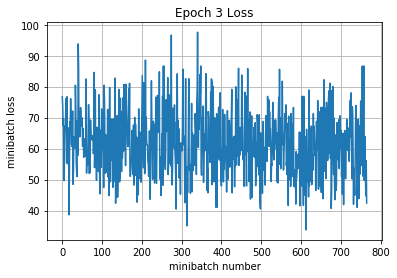

Iteration 2300: with minibatch training loss = 0.915 and accuracy of 0.64
Iteration 2400: with minibatch training loss = 0.758 and accuracy of 0.72
Iteration 2500: with minibatch training loss = 1.02 and accuracy of 0.62
Iteration 2600: with minibatch training loss = 1.15 and accuracy of 0.59
Iteration 2700: with minibatch training loss = 0.694 and accuracy of 0.75
Iteration 2800: with minibatch training loss = 0.784 and accuracy of 0.75
Iteration 2900: with minibatch training loss = 0.696 and accuracy of 0.72
Iteration 3000: with minibatch training loss = 1.11 and accuracy of 0.73
Epoch 4, Overall loss = 0.884 and accuracy of 0.703


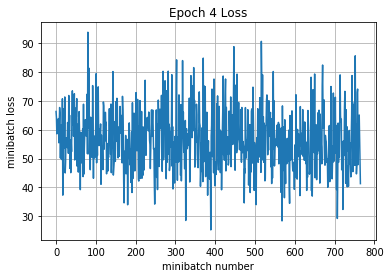

Iteration 3100: with minibatch training loss = 0.628 and accuracy of 0.78
Iteration 3200: with minibatch training loss = 0.697 and accuracy of 0.73
Iteration 3300: with minibatch training loss = 0.912 and accuracy of 0.67
Iteration 3400: with minibatch training loss = 0.485 and accuracy of 0.84
Iteration 3500: with minibatch training loss = 0.979 and accuracy of 0.69
Iteration 3600: with minibatch training loss = 0.708 and accuracy of 0.73
Iteration 3700: with minibatch training loss = 0.804 and accuracy of 0.67
Iteration 3800: with minibatch training loss = 0.66 and accuracy of 0.77
Epoch 5, Overall loss = 0.808 and accuracy of 0.729


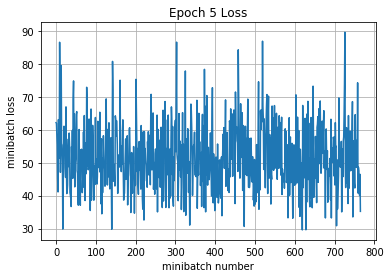

Iteration 3900: with minibatch training loss = 0.42 and accuracy of 0.84
Iteration 4000: with minibatch training loss = 0.605 and accuracy of 0.73
Iteration 4100: with minibatch training loss = 0.808 and accuracy of 0.73
Iteration 4200: with minibatch training loss = 0.98 and accuracy of 0.72
Iteration 4300: with minibatch training loss = 0.754 and accuracy of 0.73
Iteration 4400: with minibatch training loss = 0.56 and accuracy of 0.8
Iteration 4500: with minibatch training loss = 0.843 and accuracy of 0.77
Epoch 6, Overall loss = 0.757 and accuracy of 0.746


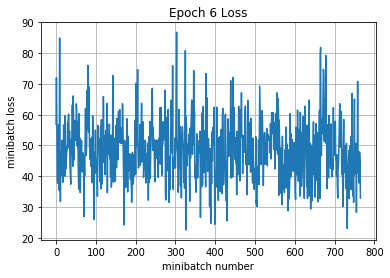

Iteration 4600: with minibatch training loss = 0.484 and accuracy of 0.86
Iteration 4700: with minibatch training loss = 0.484 and accuracy of 0.81
Iteration 4800: with minibatch training loss = 0.722 and accuracy of 0.75
Iteration 4900: with minibatch training loss = 0.637 and accuracy of 0.77
Iteration 5000: with minibatch training loss = 0.518 and accuracy of 0.88
Iteration 5100: with minibatch training loss = 0.639 and accuracy of 0.77
Iteration 5200: with minibatch training loss = 0.527 and accuracy of 0.83
Iteration 5300: with minibatch training loss = 0.498 and accuracy of 0.83
Epoch 7, Overall loss = 0.703 and accuracy of 0.768


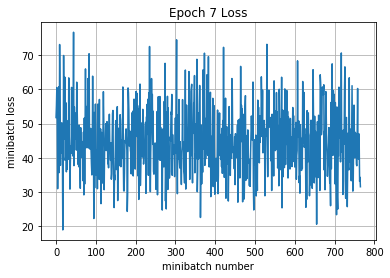

Iteration 5400: with minibatch training loss = 0.421 and accuracy of 0.89
Iteration 5500: with minibatch training loss = 0.696 and accuracy of 0.73
Iteration 5600: with minibatch training loss = 0.625 and accuracy of 0.75
Iteration 5700: with minibatch training loss = 0.664 and accuracy of 0.78
Iteration 5800: with minibatch training loss = 0.628 and accuracy of 0.8
Iteration 5900: with minibatch training loss = 0.722 and accuracy of 0.72
Iteration 6000: with minibatch training loss = 0.641 and accuracy of 0.83
Iteration 6100: with minibatch training loss = 0.513 and accuracy of 0.83
Epoch 8, Overall loss = 0.646 and accuracy of 0.785


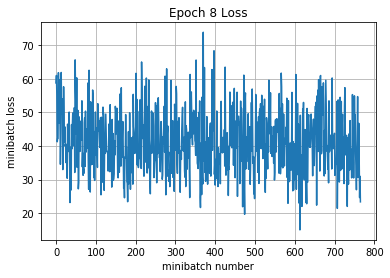

Iteration 6200: with minibatch training loss = 0.649 and accuracy of 0.81
Iteration 6300: with minibatch training loss = 0.454 and accuracy of 0.84
Iteration 6400: with minibatch training loss = 0.596 and accuracy of 0.75
Iteration 6500: with minibatch training loss = 0.587 and accuracy of 0.8
Iteration 6600: with minibatch training loss = 0.478 and accuracy of 0.84
Iteration 6700: with minibatch training loss = 0.628 and accuracy of 0.81
Iteration 6800: with minibatch training loss = 0.696 and accuracy of 0.72
Epoch 9, Overall loss = 0.615 and accuracy of 0.797


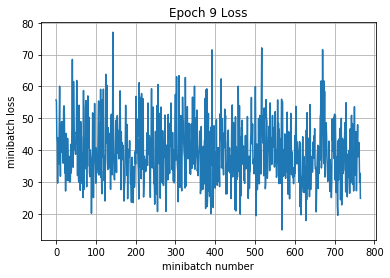

Iteration 6900: with minibatch training loss = 0.542 and accuracy of 0.8
Iteration 7000: with minibatch training loss = 0.663 and accuracy of 0.8
Iteration 7100: with minibatch training loss = 0.648 and accuracy of 0.77
Iteration 7200: with minibatch training loss = 0.538 and accuracy of 0.83
Iteration 7300: with minibatch training loss = 0.859 and accuracy of 0.73
Iteration 7400: with minibatch training loss = 0.493 and accuracy of 0.81
Iteration 7500: with minibatch training loss = 0.405 and accuracy of 0.81
Iteration 7600: with minibatch training loss = 0.759 and accuracy of 0.77
Epoch 10, Overall loss = 0.572 and accuracy of 0.814


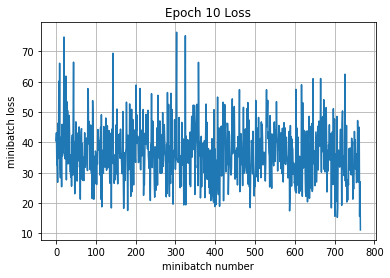

Iteration 7700: with minibatch training loss = 0.518 and accuracy of 0.78
Iteration 7800: with minibatch training loss = 0.395 and accuracy of 0.88
Iteration 7900: with minibatch training loss = 0.765 and accuracy of 0.73
Iteration 8000: with minibatch training loss = 0.936 and accuracy of 0.78
Iteration 8100: with minibatch training loss = 0.449 and accuracy of 0.84
Iteration 8200: with minibatch training loss = 0.498 and accuracy of 0.81
Iteration 8300: with minibatch training loss = 0.294 and accuracy of 0.89
Iteration 8400: with minibatch training loss = 0.461 and accuracy of 0.84
Epoch 11, Overall loss = 0.534 and accuracy of 0.824


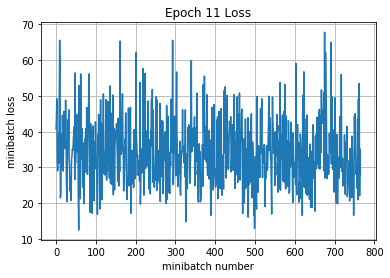

Iteration 8500: with minibatch training loss = 0.74 and accuracy of 0.81
Iteration 8600: with minibatch training loss = 0.722 and accuracy of 0.77
Iteration 8700: with minibatch training loss = 0.889 and accuracy of 0.69
Iteration 8800: with minibatch training loss = 0.462 and accuracy of 0.88
Iteration 8900: with minibatch training loss = 0.424 and accuracy of 0.91
Iteration 9000: with minibatch training loss = 0.29 and accuracy of 0.91
Iteration 9100: with minibatch training loss = 0.529 and accuracy of 0.84
Epoch 12, Overall loss = 0.502 and accuracy of 0.835


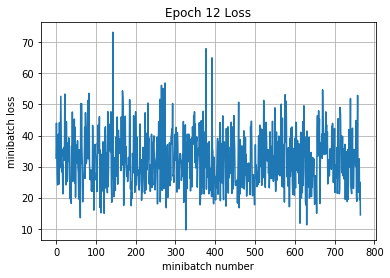

Iteration 9200: with minibatch training loss = 0.4 and accuracy of 0.88
Iteration 9300: with minibatch training loss = 0.476 and accuracy of 0.83
Iteration 9400: with minibatch training loss = 0.536 and accuracy of 0.86
Iteration 9500: with minibatch training loss = 0.318 and accuracy of 0.89
Iteration 9600: with minibatch training loss = 0.335 and accuracy of 0.91
Iteration 9700: with minibatch training loss = 0.396 and accuracy of 0.89
Iteration 9800: with minibatch training loss = 0.526 and accuracy of 0.88
Iteration 9900: with minibatch training loss = 0.312 and accuracy of 0.92
Epoch 13, Overall loss = 0.471 and accuracy of 0.846


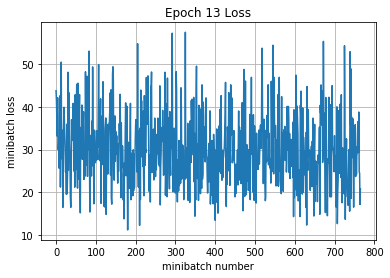

Iteration 10000: with minibatch training loss = 0.686 and accuracy of 0.84
Iteration 10100: with minibatch training loss = 0.52 and accuracy of 0.84
Iteration 10200: with minibatch training loss = 0.403 and accuracy of 0.88
Iteration 10300: with minibatch training loss = 0.403 and accuracy of 0.89
Iteration 10400: with minibatch training loss = 0.627 and accuracy of 0.84
Iteration 10500: with minibatch training loss = 0.334 and accuracy of 0.92
Iteration 10600: with minibatch training loss = 0.354 and accuracy of 0.91
Iteration 10700: with minibatch training loss = 0.36 and accuracy of 0.88
Epoch 14, Overall loss = 0.448 and accuracy of 0.854


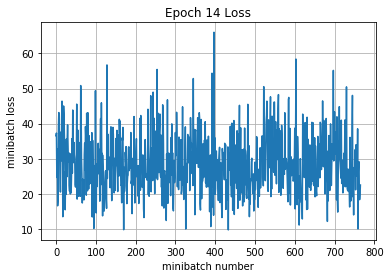

Iteration 10800: with minibatch training loss = 0.284 and accuracy of 0.91
Iteration 10900: with minibatch training loss = 0.636 and accuracy of 0.83
Iteration 11000: with minibatch training loss = 0.351 and accuracy of 0.91
Iteration 11100: with minibatch training loss = 0.37 and accuracy of 0.89
Iteration 11200: with minibatch training loss = 0.517 and accuracy of 0.86
Iteration 11300: with minibatch training loss = 0.4 and accuracy of 0.83
Iteration 11400: with minibatch training loss = 0.32 and accuracy of 0.89
Epoch 15, Overall loss = 0.406 and accuracy of 0.866


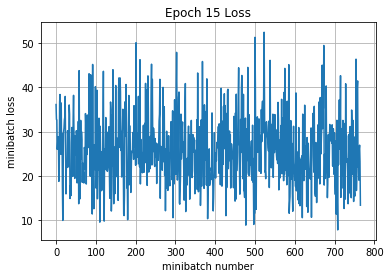

Iteration 11500: with minibatch training loss = 0.365 and accuracy of 0.84
Iteration 11600: with minibatch training loss = 0.325 and accuracy of 0.86
Iteration 11700: with minibatch training loss = 0.244 and accuracy of 0.94
Iteration 11800: with minibatch training loss = 0.326 and accuracy of 0.88
Iteration 11900: with minibatch training loss = 0.508 and accuracy of 0.83
Iteration 12000: with minibatch training loss = 0.337 and accuracy of 0.88
Iteration 12100: with minibatch training loss = 0.453 and accuracy of 0.86
Iteration 12200: with minibatch training loss = 0.371 and accuracy of 0.86
Epoch 16, Overall loss = 0.382 and accuracy of 0.874


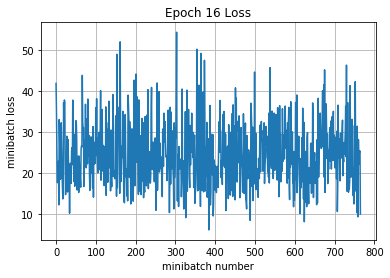

Iteration 12300: with minibatch training loss = 0.402 and accuracy of 0.84
Iteration 12400: with minibatch training loss = 0.299 and accuracy of 0.88
Iteration 12500: with minibatch training loss = 0.554 and accuracy of 0.83
Iteration 12600: with minibatch training loss = 0.409 and accuracy of 0.83
Iteration 12700: with minibatch training loss = 0.478 and accuracy of 0.88
Iteration 12800: with minibatch training loss = 0.558 and accuracy of 0.78
Iteration 12900: with minibatch training loss = 0.239 and accuracy of 0.94
Iteration 13000: with minibatch training loss = 0.401 and accuracy of 0.88
Epoch 17, Overall loss = 0.361 and accuracy of 0.883


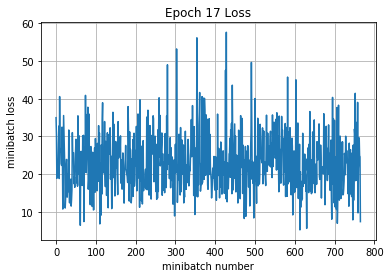

Iteration 13100: with minibatch training loss = 0.433 and accuracy of 0.88
Iteration 13200: with minibatch training loss = 0.306 and accuracy of 0.89
Iteration 13300: with minibatch training loss = 0.362 and accuracy of 0.89
Iteration 13400: with minibatch training loss = 0.313 and accuracy of 0.88
Iteration 13500: with minibatch training loss = 0.379 and accuracy of 0.88
Iteration 13600: with minibatch training loss = 0.282 and accuracy of 0.91
Iteration 13700: with minibatch training loss = 0.448 and accuracy of 0.81
Epoch 18, Overall loss = 0.349 and accuracy of 0.886


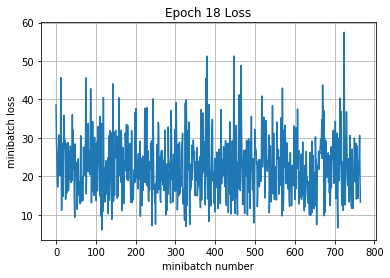

Iteration 13800: with minibatch training loss = 0.31 and accuracy of 0.89
Iteration 13900: with minibatch training loss = 0.466 and accuracy of 0.86
Iteration 14000: with minibatch training loss = 0.162 and accuracy of 0.94
Iteration 14100: with minibatch training loss = 0.321 and accuracy of 0.89
Iteration 14200: with minibatch training loss = 0.431 and accuracy of 0.88
Iteration 14300: with minibatch training loss = 0.105 and accuracy of 0.94
Iteration 14400: with minibatch training loss = 0.313 and accuracy of 0.94
Iteration 14500: with minibatch training loss = 0.341 and accuracy of 0.89
Epoch 19, Overall loss = 0.333 and accuracy of 0.893


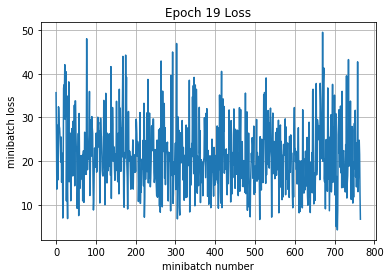

Iteration 14600: with minibatch training loss = 0.148 and accuracy of 0.95
Iteration 14700: with minibatch training loss = 0.28 and accuracy of 0.92
Iteration 14800: with minibatch training loss = 0.279 and accuracy of 0.91
Iteration 14900: with minibatch training loss = 0.168 and accuracy of 0.97
Iteration 15000: with minibatch training loss = 0.131 and accuracy of 0.97
Iteration 15100: with minibatch training loss = 0.307 and accuracy of 0.89
Iteration 15200: with minibatch training loss = 0.261 and accuracy of 0.89
Iteration 15300: with minibatch training loss = 0.328 and accuracy of 0.89
Epoch 20, Overall loss = 0.318 and accuracy of 0.895


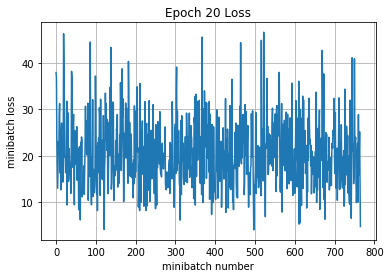

Iteration 15400: with minibatch training loss = 0.656 and accuracy of 0.77
Iteration 15500: with minibatch training loss = 0.0989 and accuracy of 0.97
Iteration 15600: with minibatch training loss = 0.4 and accuracy of 0.88
Iteration 15700: with minibatch training loss = 0.192 and accuracy of 0.94
Iteration 15800: with minibatch training loss = 0.274 and accuracy of 0.92
Iteration 15900: with minibatch training loss = 0.458 and accuracy of 0.88
Iteration 16000: with minibatch training loss = 0.49 and accuracy of 0.83
Epoch 21, Overall loss = 0.306 and accuracy of 0.903


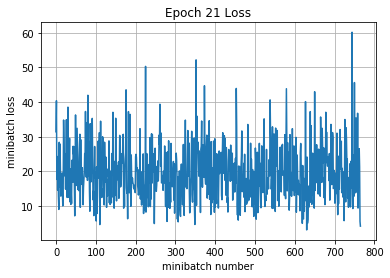

Iteration 16100: with minibatch training loss = 0.185 and accuracy of 0.94
Iteration 16200: with minibatch training loss = 0.233 and accuracy of 0.92
Iteration 16300: with minibatch training loss = 0.286 and accuracy of 0.91
Iteration 16400: with minibatch training loss = 0.413 and accuracy of 0.91
Iteration 16500: with minibatch training loss = 0.316 and accuracy of 0.89
Iteration 16600: with minibatch training loss = 0.33 and accuracy of 0.91
Iteration 16700: with minibatch training loss = 0.333 and accuracy of 0.89
Iteration 16800: with minibatch training loss = 0.26 and accuracy of 0.91
Epoch 22, Overall loss = 0.296 and accuracy of 0.906


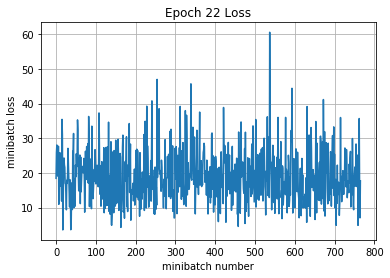

Iteration 16900: with minibatch training loss = 0.261 and accuracy of 0.92
Iteration 17000: with minibatch training loss = 0.328 and accuracy of 0.92
Iteration 17100: with minibatch training loss = 0.0995 and accuracy of 1
Iteration 17200: with minibatch training loss = 0.334 and accuracy of 0.86
Iteration 17300: with minibatch training loss = 0.138 and accuracy of 0.95
Iteration 17400: with minibatch training loss = 0.488 and accuracy of 0.84
Iteration 17500: with minibatch training loss = 0.552 and accuracy of 0.86
Iteration 17600: with minibatch training loss = 0.0843 and accuracy of 0.95
Epoch 23, Overall loss = 0.283 and accuracy of 0.911


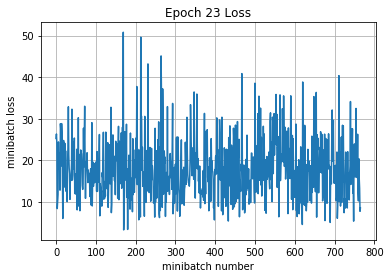

Iteration 17700: with minibatch training loss = 0.362 and accuracy of 0.91
Iteration 17800: with minibatch training loss = 0.396 and accuracy of 0.88
Iteration 17900: with minibatch training loss = 0.125 and accuracy of 0.95
Iteration 18000: with minibatch training loss = 0.186 and accuracy of 0.94
Iteration 18100: with minibatch training loss = 0.351 and accuracy of 0.84
Iteration 18200: with minibatch training loss = 0.537 and accuracy of 0.84
Iteration 18300: with minibatch training loss = 0.189 and accuracy of 0.91
Epoch 24, Overall loss = 0.269 and accuracy of 0.914


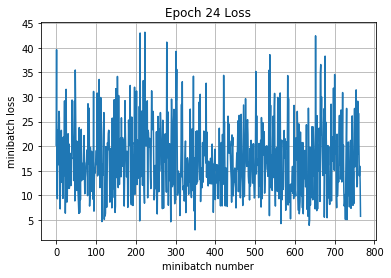

Iteration 18400: with minibatch training loss = 0.206 and accuracy of 0.94
Iteration 18500: with minibatch training loss = 0.258 and accuracy of 0.94
Iteration 18600: with minibatch training loss = 0.433 and accuracy of 0.89
Iteration 18700: with minibatch training loss = 0.215 and accuracy of 0.92
Iteration 18800: with minibatch training loss = 0.118 and accuracy of 0.95
Iteration 18900: with minibatch training loss = 0.258 and accuracy of 0.86
Iteration 19000: with minibatch training loss = 0.301 and accuracy of 0.92
Iteration 19100: with minibatch training loss = 0.171 and accuracy of 0.95
Epoch 25, Overall loss = 0.263 and accuracy of 0.917


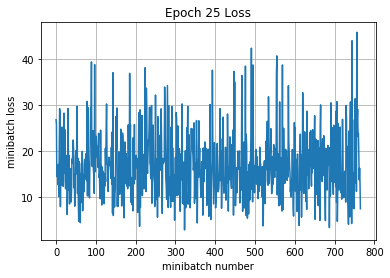

Iteration 19200: with minibatch training loss = 0.251 and accuracy of 0.94
Iteration 19300: with minibatch training loss = 0.338 and accuracy of 0.89
Iteration 19400: with minibatch training loss = 0.197 and accuracy of 0.94
Iteration 19500: with minibatch training loss = 0.28 and accuracy of 0.94
Iteration 19600: with minibatch training loss = 0.322 and accuracy of 0.88
Iteration 19700: with minibatch training loss = 0.415 and accuracy of 0.91
Iteration 19800: with minibatch training loss = 0.101 and accuracy of 0.95
Iteration 19900: with minibatch training loss = 0.246 and accuracy of 0.92
Epoch 26, Overall loss = 0.266 and accuracy of 0.918


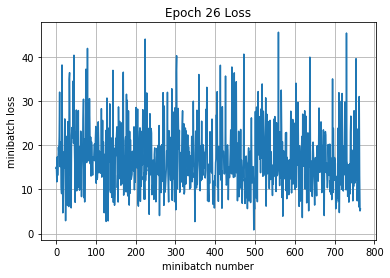

Iteration 20000: with minibatch training loss = 0.242 and accuracy of 0.91
Iteration 20100: with minibatch training loss = 0.0667 and accuracy of 0.98
Iteration 20200: with minibatch training loss = 0.328 and accuracy of 0.88
Iteration 20300: with minibatch training loss = 0.157 and accuracy of 0.95
Iteration 20400: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 20500: with minibatch training loss = 0.238 and accuracy of 0.92
Iteration 20600: with minibatch training loss = 0.189 and accuracy of 0.94
Epoch 27, Overall loss = 0.246 and accuracy of 0.922


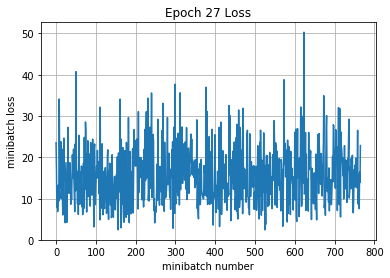

Iteration 20700: with minibatch training loss = 0.124 and accuracy of 0.97
Iteration 20800: with minibatch training loss = 0.134 and accuracy of 0.94
Iteration 20900: with minibatch training loss = 0.265 and accuracy of 0.94
Iteration 21000: with minibatch training loss = 0.309 and accuracy of 0.92
Iteration 21100: with minibatch training loss = 0.264 and accuracy of 0.92
Iteration 21200: with minibatch training loss = 0.194 and accuracy of 0.89
Iteration 21300: with minibatch training loss = 0.28 and accuracy of 0.91
Iteration 21400: with minibatch training loss = 0.255 and accuracy of 0.88
Epoch 28, Overall loss = 0.244 and accuracy of 0.925


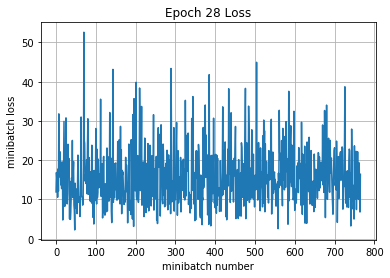

Iteration 21500: with minibatch training loss = 0.306 and accuracy of 0.91
Iteration 21600: with minibatch training loss = 0.182 and accuracy of 0.95
Iteration 21700: with minibatch training loss = 0.108 and accuracy of 0.95
Iteration 21800: with minibatch training loss = 0.323 and accuracy of 0.94
Iteration 21900: with minibatch training loss = 0.255 and accuracy of 0.91
Iteration 22000: with minibatch training loss = 0.173 and accuracy of 0.92
Iteration 22100: with minibatch training loss = 0.4 and accuracy of 0.92
Iteration 22200: with minibatch training loss = 0.448 and accuracy of 0.89
Epoch 29, Overall loss = 0.249 and accuracy of 0.924


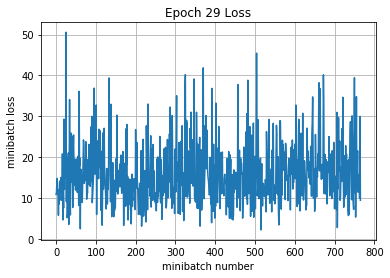

Iteration 22300: with minibatch training loss = 0.318 and accuracy of 0.92
Iteration 22400: with minibatch training loss = 0.227 and accuracy of 0.92
Iteration 22500: with minibatch training loss = 0.153 and accuracy of 0.94
Iteration 22600: with minibatch training loss = 0.45 and accuracy of 0.94
Iteration 22700: with minibatch training loss = 0.0867 and accuracy of 0.97
Iteration 22800: with minibatch training loss = 0.225 and accuracy of 0.94
Iteration 22900: with minibatch training loss = 0.309 and accuracy of 0.94
Epoch 30, Overall loss = 0.237 and accuracy of 0.927


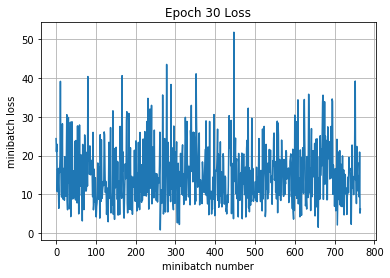

Iteration 23000: with minibatch training loss = 0.529 and accuracy of 0.84
Iteration 23100: with minibatch training loss = 0.266 and accuracy of 0.94
Iteration 23200: with minibatch training loss = 0.0959 and accuracy of 0.97
Iteration 23300: with minibatch training loss = 0.173 and accuracy of 0.94
Iteration 23400: with minibatch training loss = 0.337 and accuracy of 0.89
Iteration 23500: with minibatch training loss = 0.275 and accuracy of 0.92
Iteration 23600: with minibatch training loss = 0.231 and accuracy of 0.91
Iteration 23700: with minibatch training loss = 0.518 and accuracy of 0.91
Epoch 31, Overall loss = 0.237 and accuracy of 0.928


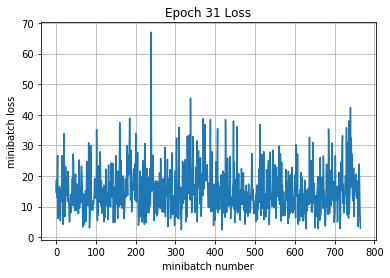

Iteration 23800: with minibatch training loss = 0.188 and accuracy of 0.95
Iteration 23900: with minibatch training loss = 0.137 and accuracy of 0.94
Iteration 24000: with minibatch training loss = 0.196 and accuracy of 0.92
Iteration 24100: with minibatch training loss = 0.8 and accuracy of 0.83
Iteration 24200: with minibatch training loss = 0.266 and accuracy of 0.91
Iteration 24300: with minibatch training loss = 0.299 and accuracy of 0.94
Iteration 24400: with minibatch training loss = 0.135 and accuracy of 0.95
Iteration 24500: with minibatch training loss = 0.264 and accuracy of 0.92
Epoch 32, Overall loss = 0.221 and accuracy of 0.934


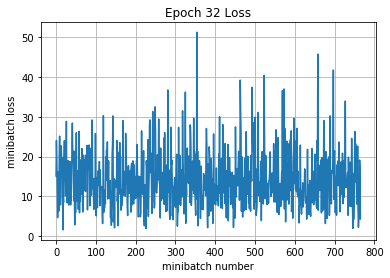

Iteration 24600: with minibatch training loss = 0.179 and accuracy of 0.92
Iteration 24700: with minibatch training loss = 0.152 and accuracy of 0.94
Iteration 24800: with minibatch training loss = 0.152 and accuracy of 0.95
Iteration 24900: with minibatch training loss = 0.169 and accuracy of 0.97
Iteration 25000: with minibatch training loss = 0.0618 and accuracy of 1
Iteration 25100: with minibatch training loss = 0.136 and accuracy of 0.94
Iteration 25200: with minibatch training loss = 0.136 and accuracy of 0.94
Epoch 33, Overall loss = 0.231 and accuracy of 0.93


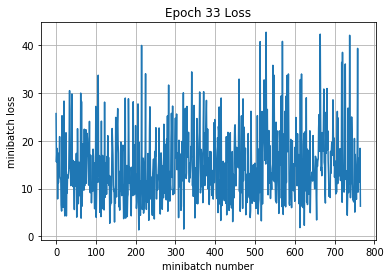

Iteration 25300: with minibatch training loss = 0.201 and accuracy of 0.94
Iteration 25400: with minibatch training loss = 0.197 and accuracy of 0.95
Iteration 25500: with minibatch training loss = 0.422 and accuracy of 0.91
Iteration 25600: with minibatch training loss = 0.16 and accuracy of 0.95
Iteration 25700: with minibatch training loss = 0.202 and accuracy of 0.94
Iteration 25800: with minibatch training loss = 0.301 and accuracy of 0.88
Iteration 25900: with minibatch training loss = 0.0919 and accuracy of 0.97
Iteration 26000: with minibatch training loss = 0.131 and accuracy of 0.95
Epoch 34, Overall loss = 0.222 and accuracy of 0.934


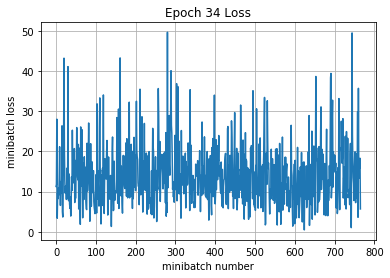

Iteration 26100: with minibatch training loss = 0.259 and accuracy of 0.94
Iteration 26200: with minibatch training loss = 0.104 and accuracy of 0.95
Iteration 26300: with minibatch training loss = 0.231 and accuracy of 0.89
Iteration 26400: with minibatch training loss = 0.125 and accuracy of 0.95
Iteration 26500: with minibatch training loss = 0.236 and accuracy of 0.95
Iteration 26600: with minibatch training loss = 0.197 and accuracy of 0.94
Iteration 26700: with minibatch training loss = 0.2 and accuracy of 0.94
Iteration 26800: with minibatch training loss = 0.252 and accuracy of 0.94
Epoch 35, Overall loss = 0.216 and accuracy of 0.936


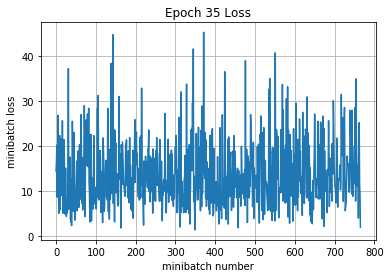

Iteration 26900: with minibatch training loss = 0.33 and accuracy of 0.91
Iteration 27000: with minibatch training loss = 0.127 and accuracy of 0.97
Iteration 27100: with minibatch training loss = 0.23 and accuracy of 0.95
Iteration 27200: with minibatch training loss = 0.167 and accuracy of 0.94
Iteration 27300: with minibatch training loss = 0.33 and accuracy of 0.92
Iteration 27400: with minibatch training loss = 0.129 and accuracy of 0.97
Iteration 27500: with minibatch training loss = 0.346 and accuracy of 0.91
Epoch 36, Overall loss = 0.214 and accuracy of 0.937


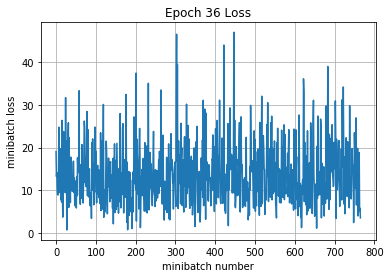

Iteration 27600: with minibatch training loss = 0.319 and accuracy of 0.89
Iteration 27700: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 27800: with minibatch training loss = 0.192 and accuracy of 0.94
Iteration 27900: with minibatch training loss = 0.226 and accuracy of 0.95
Iteration 28000: with minibatch training loss = 0.349 and accuracy of 0.91
Iteration 28100: with minibatch training loss = 0.166 and accuracy of 0.91
Iteration 28200: with minibatch training loss = 0.131 and accuracy of 0.95
Iteration 28300: with minibatch training loss = 0.184 and accuracy of 0.95
Epoch 37, Overall loss = 0.241 and accuracy of 0.931


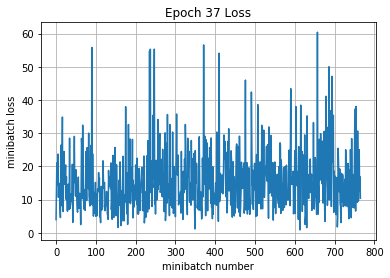

Iteration 28400: with minibatch training loss = 0.234 and accuracy of 0.91
Iteration 28500: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 28600: with minibatch training loss = 0.124 and accuracy of 0.95
Iteration 28700: with minibatch training loss = 0.268 and accuracy of 0.86
Iteration 28800: with minibatch training loss = 0.0166 and accuracy of 1
Iteration 28900: with minibatch training loss = 0.13 and accuracy of 0.95
Iteration 29000: with minibatch training loss = 0.229 and accuracy of 0.94
Iteration 29100: with minibatch training loss = 0.14 and accuracy of 0.94
Epoch 38, Overall loss = 0.21 and accuracy of 0.939


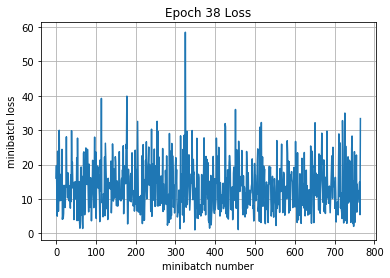

Iteration 29200: with minibatch training loss = 0.426 and accuracy of 0.89
Iteration 29300: with minibatch training loss = 0.27 and accuracy of 0.92
Iteration 29400: with minibatch training loss = 0.268 and accuracy of 0.94
Iteration 29500: with minibatch training loss = 0.0971 and accuracy of 0.95
Iteration 29600: with minibatch training loss = 0.155 and accuracy of 0.95


In [ ]:
# from tensorflow.python import debug as tf_debug
merged=tf.summary.merge_all()
sess = tf.Session()
# sess = tf_debug.TensorBoardDebugWrapperSession(sess, "e9a3475a5764:6005")
writer = tf.summary.FileWriter(logdir="/tmp/f100/...", graph=sess.graph)
sess.run(tf.global_variables_initializer())
print('Training')
run_model(writer, merged, sess,y_out,mean_loss,X_train,y_train,100,64,100,train_step,True)
print('Validation')
run_model(writer, merged, sess,y_out,mean_loss,X_val,y_val,1,64)
writer.close()

In [6]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
# print('Training')
# run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
# print('Validation')
# run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [7]:
# print('Test')
# run_model(sess,y_out,mean_loss,X_test,y_test,1,64)